This cell imports all the required libraries. We are using packages for data handling (pandas, numpy), visualization (matplotlib), financial data retrieval (yfinance), data preprocessing (MinMaxScaler), machine learning (RandomForestRegressor, TimeSeriesSplit, mean_squared_error), and deep learning (TensorFlow/Keras for LSTM modeling).


In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Download historical stock data (using ticker "UPST") from January 1st, 2019 to February 23rd, 2025. The data is reset to have a proper index, missing values are forward-filled, and the dataset is sorted by date.

In [2]:
# Download historical data for UPST up to Feb 23rd
ticker = "UPST"
data = yf.download(ticker, start="2019-01-01", end="2025-02-23")
data.reset_index(inplace=True)

# Fill missing values and ensure the data is sorted by date
data.fillna(method='ffill', inplace=True)
data.sort_values('Date', inplace=True)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-98265ac4ba24>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Defines helper functions to compute technical indicators such as Simple Moving Average (SMA) and Relative Strength Index (RSI). Then creates these features and a lagged target variable (next day’s closing price). Finally, the relevant columns are scaled to the range [0, 1] using MinMaxScaler.

In [3]:
def compute_sma(series, window):
    """Compute Simple Moving Average (SMA)."""
    return series.rolling(window=window).mean()

def compute_rsi(series, window=14):
    """Compute Relative Strength Index (RSI)."""
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=window).mean()
    ma_down = down.rolling(window=window).mean()
    rsi = 100 - (100 / (1 + ma_up / ma_down))
    return rsi

def generate_features(df):
    """Generate technical indicator features."""
    df['SMA_20'] = compute_sma(df['Close'], window=20)
    df['RSI_14'] = compute_rsi(df['Close'], window=14)
    df.dropna(inplace=True)  # Drop rows with NaN values resulting from indicator calculations
    return df

def create_lag_features(df, lag=1):
    """Create lag feature for forecasting next-day closing price."""
    df['Target'] = df['Close'].shift(-lag)  # Next day close as target
    df.dropna(inplace=True)
    return df

# Apply feature engineering functions
data = generate_features(data)
data = create_lag_features(data, lag=1)

# Scale the selected columns using MinMaxScaler
scaler = MinMaxScaler()
cols_to_scale = ['Close', 'SMA_20', 'RSI_14', 'Target']
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])


Prepares the data for a baseline model using a RandomForestRegressor. Uses TimeSeriesSplit for cross-validation to mimic real trading conditions. The model is trained and evaluated on multiple folds with Mean Squared Error (MSE) printed for each fold.

In [4]:
# Prepare features and target for the baseline model
features = ['Close', 'SMA_20', 'RSI_14']
target = 'Target'
X = data[features].values
y = data[target].values

# Use a TimeSeriesSplit to mimic real trading conditions
tscv = TimeSeriesSplit(n_splits=10)
rf_predictions = np.zeros(len(y))
fold = 1
print("RandomForest Baseline Performance:")
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize and train the RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    rf_predictions[test_index] = y_pred
    mse = mean_squared_error(y_test, y_pred)
    print(f"  Fold {fold} MSE: {mse:.5f}")
    fold += 1


RandomForest Baseline Performance:
  Fold 1 MSE: 0.06848
  Fold 2 MSE: 0.00806
  Fold 3 MSE: 0.00191
  Fold 4 MSE: 0.00014
  Fold 5 MSE: 0.00013
  Fold 6 MSE: 0.00022
  Fold 7 MSE: 0.00003
  Fold 8 MSE: 0.00002
  Fold 9 MSE: 0.00003
  Fold 10 MSE: 0.00038


Builds an LSTM-based deep learning model for regression using hourly data. We first define functions to prepare sequential data and build the LSTM model. The dataset is split into training and testing sets (80/20 split), the model is trained using early stopping, and finally, its performance is evaluated using MSE.

In [5]:
def prepare_lstm_data(df, feature_columns, target_column, sequence_length=60):
    """
    Prepare the dataset for LSTM by creating sequences of a fixed length.
    Each sequence will consist of multiple feature observations.
    """
    X_seq, y_seq = [], []
    data_values = df[feature_columns + [target_column]].values
    for i in range(len(data_values) - sequence_length):
        X_seq.append(data_values[i:i+sequence_length, :-1])
        y_seq.append(data_values[i+sequence_length - 1, -1])
    return np.array(X_seq), np.array(y_seq)

def build_lstm_model(input_shape):
    """Build and compile an LSTM model for regression."""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set sequence length and define feature/target columns for LSTM
sequence_length = 60  # using psat 60 days of data to predict the next day's closing price
feature_columns = ['Close', 'SMA_20', 'RSI_14']
target_column = 'Target'

# Prepare LSTM dataset
X_lstm, y_lstm = prepare_lstm_data(data, feature_columns, target_column, sequence_length)

# Split LSTM data into training and testing sets (using a 80/20 split)
split_index = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Build and train the LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
lstm_model = build_lstm_model(input_shape)
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])

# Evaluate LSTM model performance
y_pred_lstm = lstm_model.predict(X_test_lstm)
lstm_mse = mean_squared_error(y_test_lstm, y_pred_lstm)
print(f"LSTM Test MSE: {lstm_mse:.5f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0515
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0045
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0036
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0020
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0022
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0020
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0020
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0017
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0021
Epoch 16/50
25/

Since the features were scaled to the range [0, 1], we convert both the predictions and actual values back to their original scale. The inverse transformation uses the minimum and maximum values from the "Target" column in the scaling process.

In [6]:
# Extract the min and max for the "Target" column (which is the next day's "Close")
target_min = scaler.data_min_[3]
target_max = scaler.data_max_[3]

def inverse_transform(scaled_value):
    """Convert a scaled value back to the original price scale."""
    return scaled_value * (target_max - target_min) + target_min

actual_y = inverse_transform(y)
actual_rf_predictions = inverse_transform(rf_predictions)
actual_lstm_predictions = inverse_transform(y_pred_lstm.flatten())


This section creates two plots:

The first plot shows the RandomForest predictions against the actual closing prices.
The second plot shows the LSTM predictions against the actual closing prices.

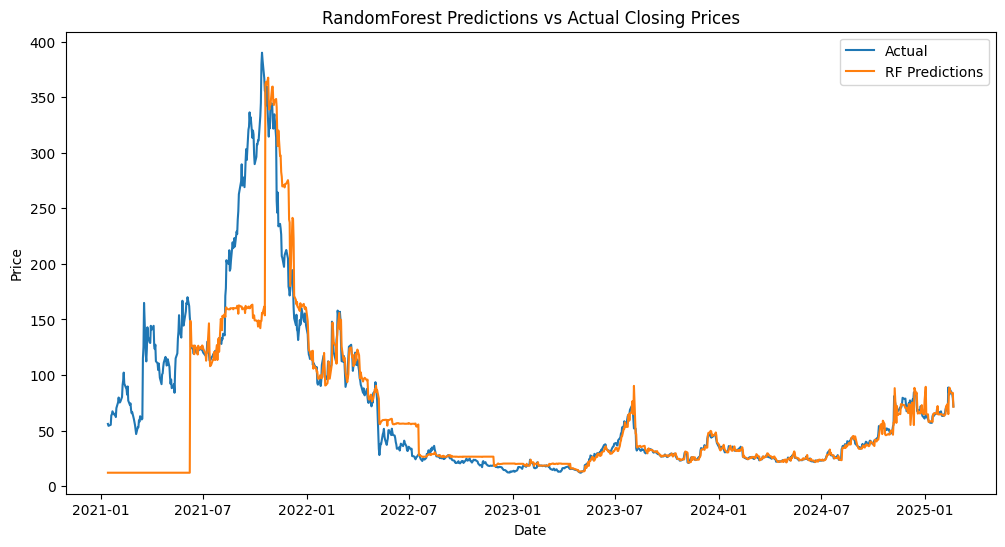

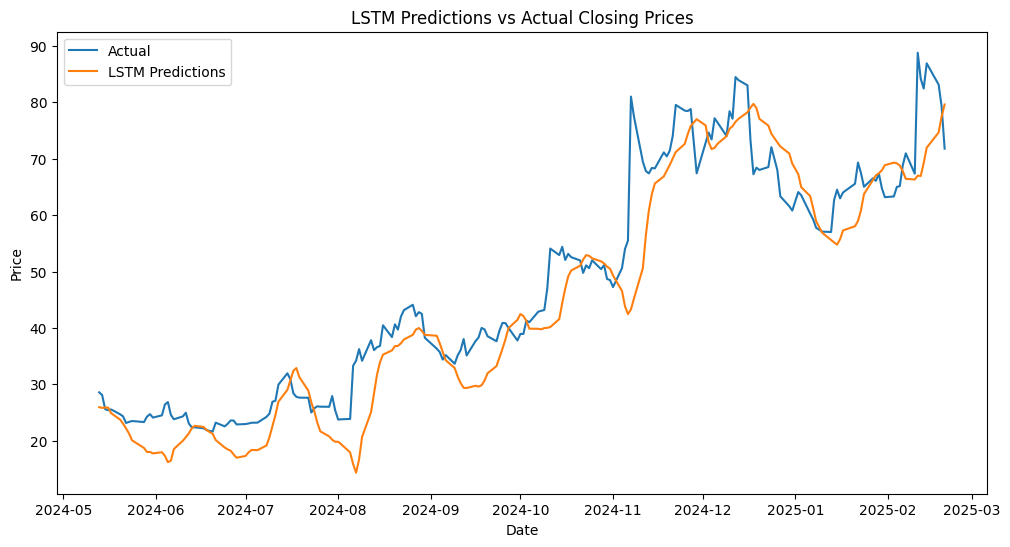

In [7]:
# Plot RandomForest predictions vs. actual prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], actual_y, label="Actual")
plt.plot(data['Date'], actual_rf_predictions, label="RF Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("RandomForest Predictions vs Actual Closing Prices")
plt.legend()
plt.show()

# Plot LSTM predictions vs. actual prices
test_dates = data['Date'].iloc[-len(actual_lstm_predictions):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_y[-len(actual_lstm_predictions):], label="Actual")
plt.plot(test_dates, actual_lstm_predictions, label="LSTM Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("LSTM Predictions vs Actual Closing Prices")
plt.legend()
plt.show()


Finally, this cell forecasts the next three days’ closing prices using both models:

RandomForest: The model predicts iteratively for the next 3 days by updating the feature set with the most recent prediction.

LSTM: The model uses the last available sequence and iteratively predicts the next day’s price, updating the sequence each time. The forecasts are converted back to actual prices.

In [8]:
# For RandomForest: Iteratively forecast the next 3 days
last_row = data.iloc[-1].copy()
future_predictions_rf = []
current_features = last_row[features].values.reshape(1, -1)

for i in range(3):
    pred_scaled = rf_model.predict(current_features)[0]
    pred_actual = inverse_transform(pred_scaled)
    future_predictions_rf.append(pred_actual)
    # Update the 'Close' feature to the predicted scaled value (keeping SMA and RSI unchanged)
    current_features[0, 0] = pred_scaled

print("RandomForest Future Predictions (Actual Price) for Feb 24th to Feb 26th:", future_predictions_rf)

# For LSTM: Iteratively forecast the next 3 days using the last available sequence
last_sequence = data[feature_columns + [target_column]].values[-sequence_length:]
future_predictions_lstm = []
current_sequence = last_sequence.copy()

for i in range(3):
    input_seq = current_sequence[:, :-1].reshape(1, sequence_length, len(feature_columns))
    pred_scaled = lstm_model.predict(input_seq)[0, 0]
    pred_actual = inverse_transform(pred_scaled)
    future_predictions_lstm.append(pred_actual)
    new_row = current_sequence[-1].copy()
    new_row[0] = pred_scaled  # Update 'Close'
    new_row[-1] = pred_scaled  # Update 'Target'
    current_sequence = np.vstack([current_sequence[1:], new_row])

print("LSTM Future Predictions (Actual Price) for Feb 24th to Feb 26th:", future_predictions_lstm)


RandomForest Future Predictions (Actual Price) for Feb 24th to Feb 26th: [71.45079940795904, 73.7091501235962, 74.23100002288817]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
LSTM Future Predictions (Actual Price) for Feb 24th to Feb 26th: [80.56238137725245, 81.03656915620036, 81.32921995982855]
